# <img src="https://raw.githubusercontent.com/alsinmr/SLEEPY_tutorial/033b817f027ebdcd6493a1f42ab9fdec290dbee8/JupyterBook/favicon.png"  width=40> <font  color = "#B00000">Relaxation Options</font>

SLEEPY has a variety of options for introducing relaxation to spin-systems. Understanding the differences between these can be important for correctly simulating complex effects. We explain and demonstrate the various options here. To keep things simple, we'll work with just single orientations.

Most of the relaxation implemented in SLEEPY follows the Lindblad method of relaxation.$^1$ Note that we have implemented single-spin relaxation, which does not include singlet/triplet relaxation. This may be added in a future update.

[1] C. Bengs, M.H. Levitt. [*J. Magn. Reson*](https://doi.org/10.1016/j.jmr.2019.106645), **2020**, 310, 106645.

In [0]:
# SETUP SLEEPY
!pip install sleepy-nmr

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Simple one-spin relaxation
In the first example, we just introduce $T_1$ and $T_2$ relaxation along the *z*-axis and in the *xy*-plane, respectively.

### Build the system

In [3]:
ex=sl.ExpSys(v0H=500,Nucs='1H',T_K=298)
L=ex.Liouvillian()
T1=1
T2=0.1
#Type of relaxation, spin-index, time constant
L.add_relax('T1',i=0,T1=T1)   
_=L.add_relax('T2',i=0,T2=T2)

### Propagate

In [4]:
seq=L.Sequence(Dt=1e-3)
rho=sl.Rho('1Hx+1Hz',['1Hx','1Hz'])
_=rho.DetProp(seq,n=5000)

### Plot the results

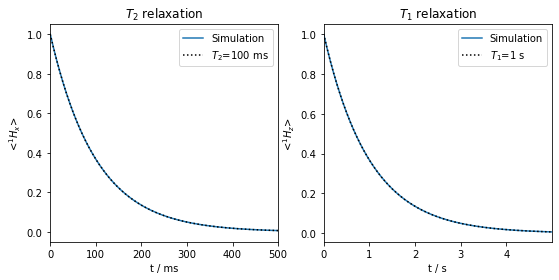

In [5]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(det_num=0,ax=ax[0],axis='ms')
ax[0].plot(rho.t_axis*1e3,np.exp(-rho.t_axis/T2),color='black',linestyle=':')
ax[0].set_xlim([-1,500])
ax[0].set_title(r'$T_2$ relaxation')
ax[0].legend(('Simulation',rf'$T_2$={T2*1e3:.0f} ms'))
rho.plot(det_num=1,axis='s',ax=ax[1])
ax[1].plot(rho.t_axis,np.exp(-rho.t_axis/T1),color='black',linestyle=':')
ax[1].set_xlim([0,rho.t_axis[-1]])
ax[1].set_title(r'$T_1$ relaxation')
_=ax[1].legend(('Simulation',rf'$T_1$={T1:.0f} s'))

Not surprisingly, we obtain perfect monoexponential relaxation, matching the input rate constants for both $T_2$ and $T_1$.

Note that $T_1$ relaxation as implemented in SLEEPY does not produce any $T_2$ relaxation. Caution should be taken to also include $T_2$ relaxation such that $2\cdot T_1\ge T_2$.$^2$

[2] D.D. Traficante. [*Conc. Magn. Reson.*](https://doi.org/10.1002/cmr.1820030305), **1991**, 3, 171-177.

### Thermalization
We may also force the magnetization to recover to its thermal equilibrium, by calling `L.add_relax('recovery')`. This function works by adding terms to all non-zero off-diagonal matrix elements of the relaxation matrix so that for the $\alpha$ and $\beta$ states of a spin, we have that 

$$
\begin{equation}
\frac{p_{eq}^\alpha}{p_{eq}^\beta}=\frac{k_{\beta\rightarrow\alpha}}{k_{\alpha\rightarrow\beta}}
\end{equation}
$$

which satisfies [detailed balance](https://en.wikipedia.org/wiki/Detailed_balance). Note that we also add these terms to coherences, so that, for example, the $S^\alpha I_x$ coherence transfers magnetization to the $S^\beta I_x$ coherence more quickly than $S^\beta I_x$ to $S^\alpha I_x$. This occurs, even though both the coherences relax to zero. This is only relevant if the longitudinal relaxation of the *S*-spin is comparable to or faster than the transverse relaxation of the *I*-spin, a situation which arises primarily for electron-nuclear systems. We demonstrate recovery for one spin. To see how this influences relaxation of coherences, see the section on [contact shifts](../Chapter5/Ch5_ContactShift.ipynb)

An important note: `L.add_relax('recovery')` should only be applied after all $T_1$ relaxation is introduced, since the adjustment to the relaxation matrix depends on what values of $T_1$ are used. Furthermore, the thermal equilibrium depends on the temperature setting of the experiment (an optional argument of ExpSys, which defaults to 298 (K)).

We now start the system without any longitudinal magnetization, since the system should recover to thermal equilibrium.

In [6]:
L.add_relax('recovery')

seq=L.Sequence(Dt=1e-3)
rho=sl.Rho('1Hx',['1Hx','1Hz'])
_=rho.DetProp(seq,n=5000)

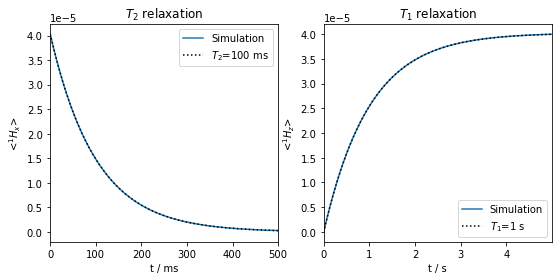

In [7]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(det_num=0,ax=ax[0],axis='ms')
ax[0].plot(rho.t_axis*1e3,np.exp(-rho.t_axis/T2)*ex.Peq[0],color='black',linestyle=':')
ax[0].set_xlim([-1,500])
ax[0].set_title(r'$T_2$ relaxation')
ax[0].legend(('Simulation',rf'$T_2$={T2*1e3:.0f} ms'))
rho.plot(det_num=1,axis='s',ax=ax[1])
ax[1].plot(rho.t_axis,(1-np.exp(-rho.t_axis/T1))*ex.Peq[0],color='black',linestyle=':')
ax[1].set_xlim([0,rho.t_axis[-1]])
ax[1].set_title(r'$T_1$ relaxation')
_=ax[1].legend(('Simulation',rf'$T_1$={T1:.0f} s'))

Now, the longitudinal magnetization starts out at zero, and recovers to the thermal equilibrium, again yielding monoexponential functions matching the input relaxation times.

## Relaxation in a tilted frame

The above relaxation methods can be applied to most spin-simulations. However, what happens if the quantization axis for a spin is tilted away from the z-axis? In this case we need to use more advanced options. We first demonstrate that the above approach fails with a tilted spin, by using a strong electron-nuclear hyperfine coupling and observing its influence on the nucleus.

To obtain tilting of the nucleus, we need to calculate the nucleus in the lab frame. We leave the electron in the rotating frame.

In [17]:
# Don't forget to set vr to zero
#It will default to 10 kHz if anisotropic interactions are present
ex=sl.ExpSys(v0H=200,Nucs=['1H','e'],vr=0,LF=[True,False],T_K=298,pwdavg='alpha0beta45')
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-1e8,Ayy=-1e8,Azz=2e8)
L=ex.Liouvillian()

T1=1
T2=0.1

#Type of relaxation, spin-index, time constant
L.add_relax('T1',i=0,T1=T1)   
_=L.add_relax('T2',i=0,T2=T2)

### Tilted frame without thermalization

In [18]:
seq=L.Sequence(Dt=1e-3)
rho=sl.Rho('1Hx+1Hz',['1Hx','1Hz'])
_=rho.DetProp(seq,n=5000)

State-space reduction: 16->8


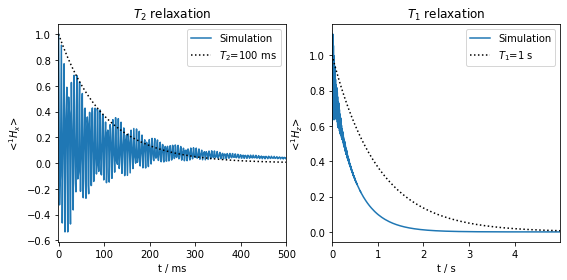

In [19]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(det_num=0,ax=ax[0],axis='ms')
ax[0].plot(rho.t_axis*1e3,np.exp(-rho.t_axis/T2),color='black',linestyle=':')
ax[0].set_xlim([-1,500])
ax[0].set_title(r'$T_2$ relaxation')
ax[0].legend(('Simulation',rf'$T_2$={T2*1e3:.0f} ms'))
rho.plot(det_num=1,axis='s',ax=ax[1])
ax[1].plot(rho.t_axis,np.exp(-rho.t_axis/T1),color='black',linestyle=':')
ax[1].set_xlim([0,rho.t_axis[-1]])
ax[1].set_title(r'$T_1$ relaxation')
_=ax[1].legend(('Simulation',rf'$T_1$={T1:.0f} s'))

The $T_2$ relaxation has a slow component, and the $T_1$ relaxation is too fast. This is because the nucleus is titled into the xy-plane, and so some $T_2$ relaxation is applied to the populations, accelerating its decay. Furthermore, parts of the coherences are relaxing with $T_1$.

Note that this is signal in the lab frame. We could downmix it to detect in the rotating frame (`rho.downmix()`), but for our purposes, this is not really necessary.

### Tilted frame with thermalization
Above, we see that the tilted frame distorts relaxation behavior using the basic SLEEPY settings. Here, we observe that it also causes thermalization to fail.

In [20]:
L.add_relax('recovery')

seq=L.Sequence(Dt=1e-3)
rho=sl.Rho('1Hx',['1Hx','1Hz'])
_=rho.DetProp(seq,n=15000)

State-space reduction: 16->8


Mixing of $T_1$ and $T_2$ furthermore distorts the thermalization process, where $T_2$ relaxation destroys some of the thermal magnetization.

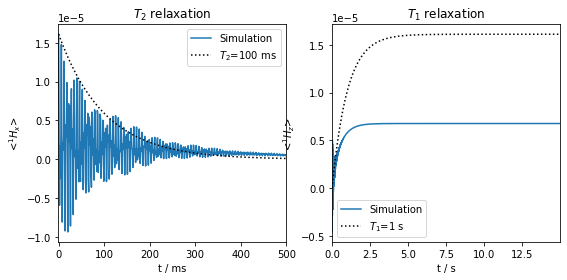

In [21]:
ax=plt.subplots(1,2,figsize=[9,4])[1]
rho.plot(det_num=0,ax=ax[0],axis='ms')
ax[0].plot(rho.t_axis*1e3,np.exp(-rho.t_axis/T2)*ex.Peq[0],color='black',linestyle=':')
ax[0].set_xlim([-1,500])
ax[0].set_title(r'$T_2$ relaxation')
ax[0].legend(('Simulation',rf'$T_2$={T2*1e3:.0f} ms'))
rho.plot(det_num=1,axis='s',ax=ax[1])
ax[1].plot(rho.t_axis,(1-np.exp(-rho.t_axis/T1))*ex.Peq[0],color='black',linestyle=':')
ax[1].set_xlim([0,rho.t_axis[-1]])
ax[1].set_title(r'$T_1$ relaxation')
_=ax[1].legend(('Simulation',rf'$T_1$={T1:.0f} s'))

The equilibrated magnetization is less than expected, because the 'recovery' option is not fully compensating the $T_2$ losses that are occuring for the nuclear populations.

### Orientation-specific relaxation

The relaxation used above uses a single relaxation matrix that is applied to all spins in the powder average, regardless of their orientation or position in a rotor cycle. However, since the tilting of the quantization axis of the nucleus depends on the orientation of the hyperfine coupling, correcting the relaxation above requires application of a relaxation matrix that is orientation-specific. This requires use of the `OS=True` option (OS:Orientation-Specific). For $T_1$ relaxation, the `OS=True` option should be paired with the `Thermal=True` option if the system should relax to thermal equilibrium. The 'recovery' option should not be paired with these settings.

Note, we may use $T_1$ and $T_2$ relaxation that is not orientation-specific, but paired with 'recovery' with `OS=True`. This is useful if the quantization axis is not tilted, but the polarization of a given spin varies with its orientation (e.g. an electron in the rotating frame will not tilt, but variation of the g-tensor may be large enough that the electron thermal equilibrium varies throughout the rotor period).

In [22]:
L.clear_relax()  #Remove existing relaxation settings
L.add_relax('T1',i=0,T1=T1,OS=True,Thermal=True)   
_=L.add_relax('T2',i=0,T2=T2,OS=True)

In [23]:
seq=L.Sequence(Dt=1e-3)
rho=sl.Rho('1Hx',['1Hx','1Hz'])
_=rho.DetProp(seq,n=15000)

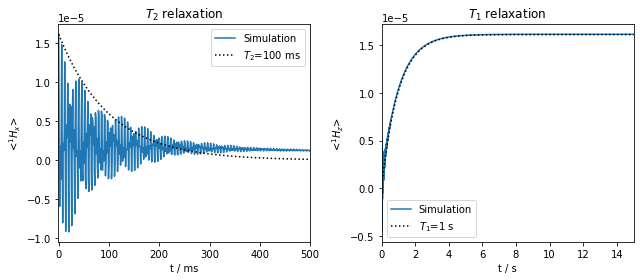

In [24]:
fig,ax=plt.subplots(1,2,figsize=[9,4])
rho.downmix()
rho.plot(det_num=0,ax=ax[0],axis='ms')
ax[0].plot(rho.t_axis*1e3,np.exp(-rho.t_axis/T2)*ex.Peq[0],color='black',linestyle=':')
ax[0].set_xlim([-1,500])
ax[0].set_title(r'$T_2$ relaxation')
ax[0].legend(('Simulation',rf'$T_2$={T2*1e3:.0f} ms'))
rho.plot(det_num=1,axis='s',ax=ax[1])
ax[1].plot(rho.t_axis,(1-np.exp(-rho.t_axis/T1))*ex.Peq[0],color='black',linestyle=':')
ax[1].set_xlim([0,rho.t_axis[-1]])
ax[1].set_title(r'$T_1$ relaxation')
ax[1].legend(('Simulation',rf'$T_1$={T1:.0f} s'))
fig.tight_layout()

The desired relaxation rates are recovered. Note that some $\langle ^1H_x\rangle$ will remain even at infinite time. This is due to the nuclear quantization axis lying partly in the *xy*-plane, so the magnetization aligns there at thermal equilibrium. Similarly, some oscillation is observed at the beginning of the $T_1$ curve, which is the result of coherences oscillating in the *z*-direction. These are not errors, but simply what happens with a tilted quantization axis (however, the spectrometer cannot *see* static magnetization, so the constant part of the x-signal would not actually show up in an experiment). 

Orientation-specific relaxation is particularly important for calculating the [pseudo-contact shift](../Chapter5/Ch5_PseudoContactShift.ipynb), although should also be used for DNP experiments where the nucleus is titled by the electron, especially to correct polarization leakage as observed above.

Note that orientation-specific relaxation is spin-specific, and so may yield unexpected behaviors when two spins are coupled in a triplet configuration, since the relaxation in this case is no longer independent.

## Thermalizing relaxation due to dynamics

For some calculations, we want to see how a dynamic process induces relaxation, and in other simulations, we may want to see how relaxation affects some process or how polarization is transferred. In the former case, we do not introduce any relaxation directly, but instead add an exchange process, in which case magnetization can only be destroyed. In the latter case, we may introduce recovery of the magnetization, especially in case we are interested in polarization transfer. 

Occasionally, we would like to see how specific dynamics processes result in polarization transfer. This is especially the case for [Overhauser](../Chapter4/Ch4_OverhauserEffect.ipynb) and [Nuclear Overhauser](../Chapter2/Ch2_T1_NOE.ipynb) effects. But, it is sometimes impractical to do this if polarization is only being destroyed. Therefore, we would like to thermalize these systems as well. We can do this by adding a correction term to the Liouville matrix, which is added with by running `L.add_relax('DynamicThermal')`. Here we consider a simple two-spin system undergoing exchange to induce $T_1$ relaxation.

### Build the system

In [16]:
# Lab frame for T1 relaxation
ex0=sl.ExpSys(500,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta45')
ex0.set_inter('dipole',i0=0,i1=1,delta=22000)
ex1=ex0.copy()
ex1.set_inter('dipole',i0=0,i1=1,delta=22000,euler=[0,30*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-9))

### Propagate and plot

In [69]:
seq=L.Sequence(Dt=0.1)
rho=sl.Rho('15Nz+1Hz',['15Nz','1Hz'])
_=rho.DetProp(seq,n=1000)

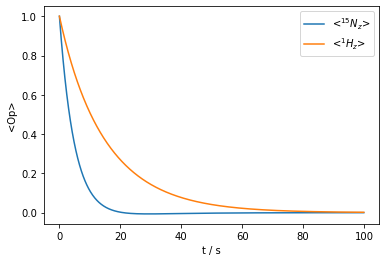

In [70]:
_=rho.plot(axis='s')

The dynamic process destroys the polarization on both spins.

### With 'DynamicThermal' option

In [71]:
_=L.add_relax('DynamicThermal')

In [72]:
seq=L.Sequence(Dt=0.1)
rho=sl.Rho('zero',['15Nz','1Hz']) #Start without any magnetization
_=rho.DetProp(seq,n=1000)

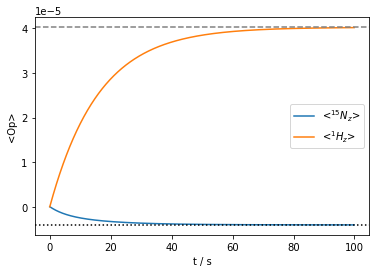

In [73]:
ax=rho.plot()
xl=ax.get_xlim()
ax.set_xlim(xl)
ax.plot(xl,ex0.Peq[0]*np.ones(2),linestyle=':',color='black')
_=ax.plot(xl,ex0.Peq[1]*np.ones(2),linestyle='--',color='grey')

As we see, both spins arive at their thermal polarization using the 'DynamicThermal' option.

This option may be used in particular to investigate NOE enhancements, or coupled longitudinal relaxation of spins. See $T_1$ and NOE for [solution](../Chapter2/Ch2_T1_NOE.ipynb) and [solids](../Chapter3/Ch3_T1_NOE.ipynb), and the DNP [Overhauser Effect](../Chapter4/Ch4_OverhauserEffect.ipynb).

### Limitations of 'DynamicThermal'

There are some limitations to this approach, due to numerical stability for very fast motions (see [$T_1$ limits](../Chapter2/Ch2_T1_limits.ipynb)), and also because it does not correctly achieve thermalization of the coherences. The latter limitation we demonstrate here. We create a system with a fast-relaxing electron due to dynamics, and add thermalization to it, to see if we can obtain a [contact shift](../Chapter5/Ch5_ContactShift.ipynb) on the nucleus.

We run the calculation twice, once with a 1 ns correlation time on the motion, inducing only slow electron $T_1$ relaxation, and then with a 1 ps correlation time, inducing fast electron $T_1$ relaxation. Only the latter will cause the proton signal to collapse into a single peak. We will then add thermalization, via `L.add_relax('DynamicThermal')`, but we fail to produce the contact shift, due to incorrect thermalization of the coherences.

In [74]:
gxx,gyy,gzz=2,2,2.05
ex0=sl.ExpSys(200,Nucs=['1H','e'],vr=0,T_K=50,LF=True,pwdavg='alpha0beta45')
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=1e6,Ayy=1e6,Azz=1e6)
ex1=ex0.copy()
ex1.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[0,np.pi/2,0])

L=sl.Liouvillian(ex0,ex1)
L.kex=sl.Tools.twoSite_kex(1e-9)

seq=L.Sequence(Dt=5e-11)
rho_1ns=sl.Rho('ez','ez')
_=rho_1ns.DetProp(seq,n=15000)

L.kex=sl.Tools.twoSite_kex(1e-12)

rho_1ps=sl.Rho('ez','ez')
_=rho_1ps.DetProp(seq,n=15000)

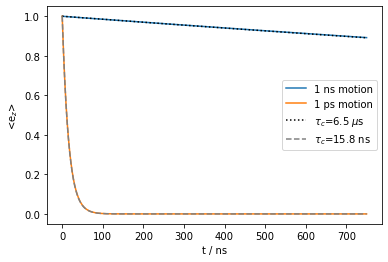

In [75]:
ax=rho_1ns.plot(axis='ns')
rho_1ps.plot(axis='ns',ax=ax)
T1_1ns=6.5e-6
T1_1ps=15.8e-9
ax.plot(rho_1ns.t_axis*1e9,np.exp(-rho_1ns.t_axis/T1_1ns),color='black',linestyle=':')
ax.plot(rho_1ns.t_axis*1e9,np.exp(-rho_1ns.t_axis/T1_1ps),color='grey',linestyle='--')
_=ax.legend(('1 ns motion','1 ps motion',rf'$\tau_c$={T1_1ns*1e6:.1f} $\mu$s',rf'$\tau_c$={T1_1ps*1e9:.1f} ns'))

We induce a very slow electron $T_1$ relaxation with the 1 ns motion (6.5 μs), but an electron $T_1$ of 15.8 ns with the 1 ps motion. We next see how this influences the $^1$H lineshape.

In [76]:
Upi2=L.Udelta('1H',np.pi/2,np.pi/2)
L.kex=sl.Tools.twoSite_kex(1e-9)

seq=L.Sequence(Dt=6e-7)
rho_1ns=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ns.DetProp(seq,n=1000)

L.kex=sl.Tools.twoSite_kex(1e-12)

rho_1ps=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ps.DetProp(seq,n=1000)

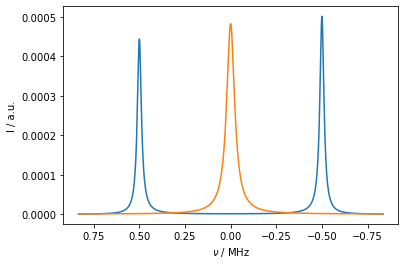

In [77]:
ax=rho_1ns.plot(FT=True,axis='MHz',apodize=True)
_=rho_1ps.plot(FT=True,axis='MHz',apodize=True,ax=ax)

For slow electron relaxation, we obtain two peaks, with different intensities due to different populations of the two electron states. For fast relaxation, the peaks merge into a single peak. This should yield a contact shift, but since the system is not thermalized, no contact shift appears.

Below, we thermalize the system with `DynamicThermal`, but because this method does not thermalize the coherences, we still do not expect a contact shift.

In [78]:
L.add_relax('DynamicThermal')

L.kex=sl.Tools.twoSite_kex(1e-9)

seq=L.Sequence(Dt=5e-11)
rho_1ns=sl.Rho('zero','ez')
_=rho_1ns.DetProp(seq,n=1000)

L.kex=sl.Tools.twoSite_kex(1e-12)

rho_1ps=sl.Rho('zero','ez')
_=rho_1ps.DetProp(seq,n=1000)

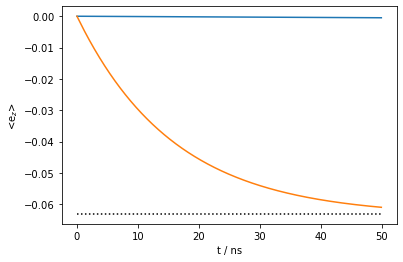

In [79]:
ax=rho_1ns.plot(axis='ns')
rho_1ps.plot(axis='ns',ax=ax)
_=ax.plot(rho_1ns.t_axis[[0,-1]]*1e9,np.ones(2)*ex0.Peq[1],linestyle=':',color='black')

We first check that the electron z-magnetization is correctly thermalized, as can be seen above.

In [80]:
L.kex=sl.Tools.twoSite_kex(1e-9)

seq=L.Sequence(Dt=6e-7)
rho_1ns=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ns.DetProp(seq,n=1000)

L.kex=sl.Tools.twoSite_kex(1e-12)

rho_1ps=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ps.DetProp(seq,n=1000)

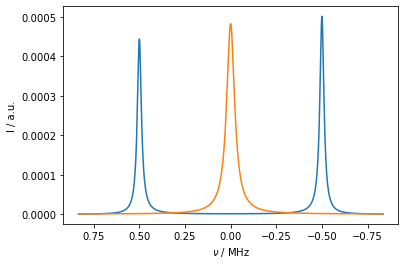

In [81]:
ax=rho_1ns.plot(FT=True,axis='MHz',apodize=True)
_=rho_1ps.plot(FT=True,axis='MHz',apodize=True,ax=ax)

With slow motion, we obtain two peaks with different peak heights. However, for fast motion, we still do not observe a contact shift, as expected, due to incorrect thermalization of the coherences. 

Finally, we re-build this system with explicit electron relaxation, using Lindblad thermalization, to obtain the correct contact shift. We will explicitly input the 15.8 ns electron $T_1$ that was induced by motion above.

In [82]:
L=ex0.Liouvillian()
Upi2=L.Udelta('1H',np.pi/2,np.pi/2)

seq=L.Sequence(Dt=6e-7)
L.add_relax('T2',i=1,T2=T1_1ns,OS=True)
L.add_relax('T1',i=1,T1=T1_1ns,OS=True,Thermal=True)

rho_1ns=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ns.DetProp(seq,n=1000)

# Note: we should use OS=True because we're in the LF for the electron
L.add_relax('T2',i=1,T2=T1_1ps,OS=True)
L.add_relax('T1',i=1,T1=T1_1ps,OS=True,Thermal=True)

rho_1ps=Upi2*sl.Rho('Thermal','1Hp')
_=rho_1ps.DetProp(seq,n=1000)

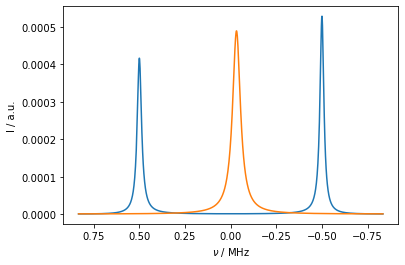

In [83]:
ax=rho_1ns.plot(FT=True,axis='MHz',apodize=True)
_=rho_1ps.plot(FT=True,axis='MHz',apodize=True,ax=ax)

We obtain a very similar result as before, *however*, now the averaged line has been shifted towards the large peak, which is brought about by having the correct thermalization behavior.

## Summary

### 1. Basic relaxation can be included using:
```
L.add_relax('T1',i=...,T1=...)
L.add_relax('T2',i=...,T2=...)
L.add_relax('recovery')  # Optional for thermalization
```
### 2. If quantization axis for a spin is tilted, use:
```
L.add_relax('T1',i=...,T1=...,OS=True,Thermal=True) #Thermal adds thermalization
L.add_relax('T2',i=...,T2=...,OS=True)
```
### 3. If the quantization axis is not tilted, but the polarization varies, use:
```
L.add_relax('T1',i=...,T1=...)
L.add_relax('T2',i=...,T2=...)
L.add_relax('recovery',OS=True)  # Orientation-specific polarization
```
### 4. If relaxation is induced explicitely by dynamics, use:
```
L.add_relax('DynamicThermal')
```
*`DynamicThermal` will not produce correct thermalization of coherences!*